In [1]:
# Import necessary libraries
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf
import numpy as np
from functools import partial
import glob, os
import pickle
import copy

In [2]:
# User inputs
data_train_len = 20  # Number of training data files
data_name = 'KS_Eqn_exp1'  # Prefix of data files
folder_name = 'KS_exp1g/'  # Folder to be created for saved output

In [3]:
# Find the model with lowest validation error
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(pkl_file)
print(params['minTest'])
print(params['minTrain'])


KS_exp1g/KS_Eqn_exp1_2019_05_11_09_29_24_291422_model.pkl
0.0920247882604599
0.08896081149578094


In [4]:
# Create numpy arrays with data

# Use these lines to load all data
data_train = np.load(('./data/%s_train1_x.npy' % (data_name)))
data_val = np.load(('./data/%s_val_x.npy' % data_name))
#data_test = np.load(('./data/%s_test_x.npy' % data_name))


In [5]:
import helperfns_convnet

max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
data_val_tensor = helperfns_convnet.stack_data(data_val, max_shifts_to_stack, params['val_len_time'])
data_train_tensor = helperfns_convnet.stack_data(data_train, max_shifts_to_stack, params['train_len_time'][0])
#data_test_tensor = helperfns_convnet.stack_data(data_test, max_shifts_to_stack, params['val_len_time'])

In [37]:
# Run a session to get encoded (initial condition), prediction (final time), loss
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    
    train_encoded, train_outputs, train_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_151/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_train_tensor})   
    val_encoded, val_outputs, val_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_151/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_val_tensor}) 
    test_encoded, test_outputs, test_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_151/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_test_tensor}) 
    
    
    #train_encoded, train_outputs, train_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_5/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_train_tensor})   
    #val_encoded, val_outputs, val_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_5/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_val_tensor}) 
    #test_encoded, test_outputs, test_loss = sess.run(["encoder/v_k/Exp:0","decoder_outer_5/outputs/BiasAdd:0","loss:0"], feed_dict={"x:0": data_test_tensor}) 
    
    #mu_pred = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/mu:0"))
    print(train_loss)
    print(val_loss)
    print(test_loss)
    #print(mu_pred)
     
    

INFO:tensorflow:Restoring parameters from ./Burgers_exp21l/Burgers_Eqn_exp21_2019_03_19_22_15_50_742074_model.ckpt
[0.00706893]
[0.00677489]
[0.01225518]


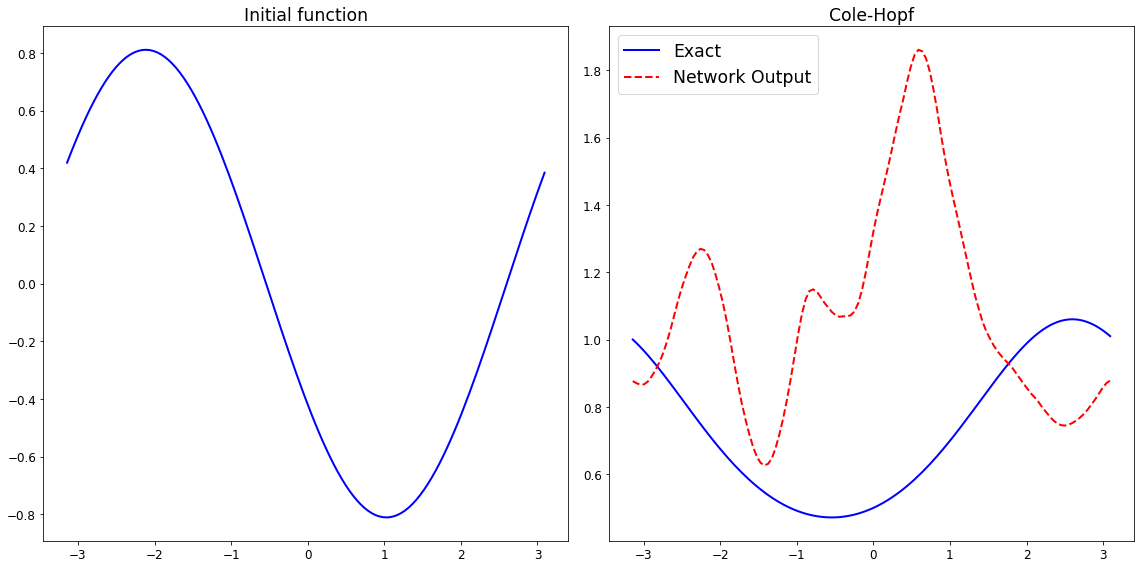

In [16]:
# Plot Cole-Hopf
from scipy.integrate import cumtrapz

# Inputs
eps = 1
mu = 1
data = 'val'  # 'train', 'val', or 'test'
ind = 10000    # index of initial condition

if data == 'train':
    encoded = train_encoded
    data_tensor = data_train_tensor
elif data == 'val':
    encoded = val_encoded
    data_tensor = data_val_tensor
else:
    encoded = test_encoded
    data_tensor = data_test_tensor

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]  
    
f = data_tensor[0,ind,:]
int_vec = cumtrapz(f, x_pts, initial=0)
v = np.exp(-eps*int_vec/(2*mu))


f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.plot(x_pts, data_tensor[0,ind,:], "b-", linewidth=2)
ax1.set_title('Initial function', fontsize='xx-large')
ax2.plot(x_pts, v, "b-", linewidth=2)
ax2.plot(x_pts, encoded[ind,:], "r--", linewidth=2)
ax2.set_title('Cole-Hopf', fontsize='xx-large')
ax2.legend(['Exact','Network Output'], loc=2, fontsize='xx-large')
    
plt.tight_layout()
plt.show()
#plt.savefig('Exp21f_Encoded')
    
    

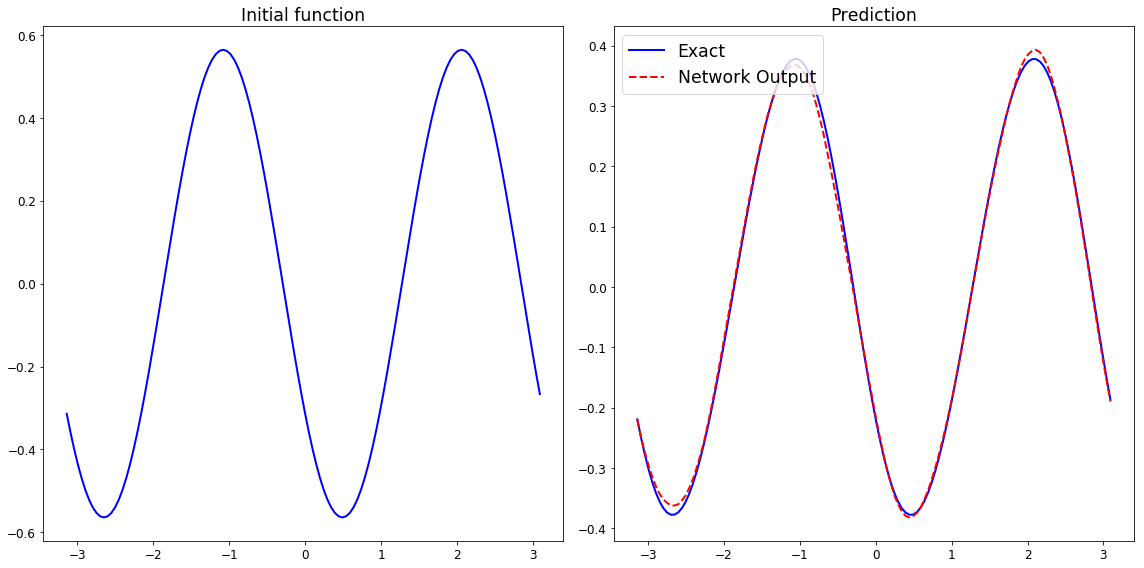

In [88]:
# Plot prediction 

# Inputs
eps = 1
mu = 1
data = 'test'  # 'train', 'val', or 'test'
ind = 1    # index of initial condition

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = test_outputs
    data_tensor = data_test_tensor


x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
    
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.plot(x_pts, data_tensor[0,ind,:], "b-", linewidth=2)
ax1.set_title('Initial function', fontsize='xx-large')
ax2.plot(x_pts, data_tensor[50,ind,:], "b-", linewidth=2)
ax2.plot(x_pts, outputs[ind,:], "r--", linewidth=2)
ax2.set_title('Prediction', fontsize='xx-large')
ax2.legend(['Exact','Network Output'], loc=2, fontsize='xx-large')
    
plt.tight_layout()
plt.show()
#plt.savefig('Exp21f_Pred')

In [89]:
# List all graph operations (if necessary to do more post processing)
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
     
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        print(op.name)
        
    
    

INFO:tensorflow:Restoring parameters from ./Burgers_exp21l/Burgers_Eqn_exp21_2019_03_19_22_15_50_742074_model.ckpt
x
strided_slice/stack
strided_slice/stack_1
strided_slice/stack_2
strided_slice
Squeeze
Identity
encoder/add/y
encoder/add
encoder/log_uk
encoder/log_uk_reshaped/shape
encoder/log_uk_reshaped
encoder/hidden1_encode/kernel/Initializer/truncated_normal/shape
encoder/hidden1_encode/kernel/Initializer/truncated_normal/mean
encoder/hidden1_encode/kernel/Initializer/truncated_normal/stddev
encoder/hidden1_encode/kernel/Initializer/truncated_normal/TruncatedNormal
encoder/hidden1_encode/kernel/Initializer/truncated_normal/mul
encoder/hidden1_encode/kernel/Initializer/truncated_normal
encoder/hidden1_encode/kernel
encoder/hidden1_encode/kernel/Assign
encoder/hidden1_encode/kernel/read
encoder/hidden1_encode/kernel/Regularizer/l2_regularizer/scale
encoder/hidden1_encode/kernel/Regularizer/l2_regularizer/L2Loss
encoder/hidden1_encode/kernel/Regularizer/l2_regularizer
encoder/hidden1

decoder_inner_6/MatMul
Identity_64
decoder_outer_6/log_vkplus1
decoder_outer_6/log_vkplus1_reshaped/shape
decoder_outer_6/log_vkplus1_reshaped
decoder_outer_6/hidden1_decode/convolution/Shape
decoder_outer_6/hidden1_decode/convolution/dilation_rate
decoder_outer_6/hidden1_decode/convolution/ExpandDims/dim
decoder_outer_6/hidden1_decode/convolution/ExpandDims
decoder_outer_6/hidden1_decode/convolution/ExpandDims_1/dim
decoder_outer_6/hidden1_decode/convolution/ExpandDims_1
decoder_outer_6/hidden1_decode/convolution/Conv2D
decoder_outer_6/hidden1_decode/convolution/Squeeze
decoder_outer_6/hidden1_decode/BiasAdd
decoder_outer_6/hidden1_decode/Relu
decoder_outer_6/mul
decoder_outer_6/hidden2_decode/reduction_indices
decoder_outer_6/hidden2_decode
decoder_outer_6/outputs/MatMul
decoder_outer_6/outputs/BiasAdd
Identity_65
Const_59
decoder_inner_7/MatMul
Identity_66
decoder_outer_7/log_vkplus1
decoder_outer_7/log_vkplus1_reshaped/shape
decoder_outer_7/log_vkplus1_reshaped
decoder_outer_7/hidd

Identity_182
decoder_outer_79/log_vkplus1
decoder_outer_79/log_vkplus1_reshaped/shape
decoder_outer_79/log_vkplus1_reshaped
decoder_outer_79/hidden1_decode/convolution/Shape
decoder_outer_79/hidden1_decode/convolution/dilation_rate
decoder_outer_79/hidden1_decode/convolution/ExpandDims/dim
decoder_outer_79/hidden1_decode/convolution/ExpandDims
decoder_outer_79/hidden1_decode/convolution/ExpandDims_1/dim
decoder_outer_79/hidden1_decode/convolution/ExpandDims_1
decoder_outer_79/hidden1_decode/convolution/Conv2D
decoder_outer_79/hidden1_decode/convolution/Squeeze
decoder_outer_79/hidden1_decode/BiasAdd
decoder_outer_79/hidden1_decode/Relu
decoder_outer_79/mul
decoder_outer_79/hidden2_decode/reduction_indices
decoder_outer_79/hidden2_decode
decoder_outer_79/outputs/MatMul
decoder_outer_79/outputs/BiasAdd
Identity_183
decoder_outer_80/log_vkplus1
decoder_outer_80/log_vkplus1_reshaped/shape
decoder_outer_80/log_vkplus1_reshaped
decoder_outer_80/hidden1_decode/convolution/Shape
decoder_outer_

strided_slice_52/stack_2
strided_slice_52
Squeeze_52
sub
Square_1
Mean_2/reduction_indices
Mean_2
Rank_1
range_1/start
range_1/delta
range_1
Mean_3
truediv
mul/x
mul
add_1
strided_slice_53/stack
strided_slice_53/stack_1
strided_slice_53/stack_2
strided_slice_53
Squeeze_53
Square_2
Mean_4/reduction_indices
Mean_4
Rank_2
range_2/start
range_2/delta
range_2
Mean_5
add_2/y
add_2
strided_slice_54/stack
strided_slice_54/stack_1
strided_slice_54/stack_2
strided_slice_54
Squeeze_54
sub_1
Square_3
Mean_6/reduction_indices
Mean_6
Rank_3
range_3/start
range_3/delta
range_3
Mean_7
truediv_1
mul_1/x
mul_1
add_3
strided_slice_55/stack
strided_slice_55/stack_1
strided_slice_55/stack_2
strided_slice_55
Squeeze_55
Square_4
Mean_8/reduction_indices
Mean_8
Rank_4
range_4/start
range_4/delta
range_4
Mean_9
add_4/y
add_4
strided_slice_56/stack
strided_slice_56/stack_1
strided_slice_56/stack_2
strided_slice_56
Squeeze_56
sub_2
Square_5
Mean_10/reduction_indices
Mean_10
Rank_5
range_5/start
range_5/delta
ran

Mean_194
Rank_97
range_97/start
range_97/delta
range_97
Mean_195
truediv_48
mul_48/x
mul_48
add_97
strided_slice_149/stack
strided_slice_149/stack_1
strided_slice_149/stack_2
strided_slice_149
Squeeze_149
Square_98
Mean_196/reduction_indices
Mean_196
Rank_98
range_98/start
range_98/delta
range_98
Mean_197
add_98/y
add_98
strided_slice_150/stack
strided_slice_150/stack_1
strided_slice_150/stack_2
strided_slice_150
Squeeze_150
sub_49
Square_99
Mean_198/reduction_indices
Mean_198
Rank_99
range_99/start
range_99/delta
range_99
Mean_199
truediv_49
mul_49/x
mul_49
add_99
strided_slice_151/stack
strided_slice_151/stack_1
strided_slice_151/stack_2
strided_slice_151
Squeeze_151
Square_100
Mean_200/reduction_indices
Mean_200
Rank_100
range_100/start
range_100/delta
range_100
Mean_201
add_100/y
add_100
strided_slice_152/stack
strided_slice_152/stack_1
strided_slice_152/stack_2
strided_slice_152
Squeeze_152
sub_50
Square_101
Mean_202/reduction_indices
Mean_202
Rank_101
range_101/start
range_101/de

Mean_404/reduction_indices
Mean_404
Rank_202
range_202/start
range_202/delta
range_202
Mean_405
add_202/y
add_202
sub_101
Square_203
Mean_406/reduction_indices
Mean_406
Const_154
Mean_407
truediv_101
mul_101/x
mul_101
add_203
MatMul_52
Squeeze_254
Square_204
Mean_408/reduction_indices
Mean_408
Rank_203
range_203/start
range_203/delta
range_203
Mean_409
add_204/y
add_204
sub_102
Square_205
Mean_410/reduction_indices
Mean_410
Const_155
Mean_411
truediv_102
mul_102/x
mul_102
add_205
MatMul_53
Squeeze_255
Square_206
Mean_412/reduction_indices
Mean_412
Rank_204
range_204/start
range_204/delta
range_204
Mean_413
add_206/y
add_206
sub_103
Square_207
Mean_414/reduction_indices
Mean_414
Const_156
Mean_415
truediv_103
mul_103/x
mul_103
add_207
MatMul_54
Squeeze_256
Square_208
Mean_416/reduction_indices
Mean_416
Rank_205
range_205/start
range_205/delta
range_205
Mean_417
add_208/y
add_208
sub_104
Square_209
Mean_418/reduction_indices
Mean_418
Const_157
Mean_419
truediv_104
mul_104/x
mul_104
add_2

add_346/y
add_346
MatMul_146
MatMul_147
sub_173
Square_347
Mean_694/reduction_indices
Mean_694
Const_249
Mean_695
truediv_173
mul_173/x
mul_173
add_347
Square_348
Mean_696/reduction_indices
Mean_696
Const_250
Mean_697
add_348/y
add_348
MatMul_148
MatMul_149
sub_174
Square_349
Mean_698/reduction_indices
Mean_698
Const_251
Mean_699
truediv_174
mul_174/x
mul_174
add_349
Square_350
Mean_700/reduction_indices
Mean_700
Const_252
Mean_701
add_350/y
add_350
MatMul_150
MatMul_151
sub_175
Square_351
Mean_702/reduction_indices
Mean_702
Const_253
Mean_703
truediv_175
mul_175/x
mul_175
add_351
Square_352
Mean_704/reduction_indices
Mean_704
Const_254
Mean_705
add_352/y
add_352
MatMul_152
MatMul_153
sub_176
Square_353
Mean_706/reduction_indices
Mean_706
Const_255
Mean_707
truediv_176
mul_176/x
mul_176
add_353
Square_354
Mean_708/reduction_indices
Mean_708
Const_256
Mean_709
add_354/y
add_354
MatMul_154
MatMul_155
sub_177
Square_355
Mean_710/reduction_indices
Mean_710
Const_257
Mean_711
truediv_177
mu

strided_slice_322/stack_1
strided_slice_322/stack_2
strided_slice_322
Squeeze_372
sub_236
Square_473
Mean_946/reduction_indices
Mean_946
Rank_321
range_321/start
range_321/delta
range_321
Mean_947
truediv_236
mul_236/x
mul_236
add_473
strided_slice_323/stack
strided_slice_323/stack_1
strided_slice_323/stack_2
strided_slice_323
Squeeze_373
Square_474
Mean_948/reduction_indices
Mean_948
Rank_322
range_322/start
range_322/delta
range_322
Mean_949
add_474/y
add_474
strided_slice_324/stack
strided_slice_324/stack_1
strided_slice_324/stack_2
strided_slice_324
Squeeze_374
sub_237
Square_475
Mean_950/reduction_indices
Mean_950
Rank_323
range_323/start
range_323/delta
range_323
Mean_951
truediv_237
mul_237/x
mul_237
add_475
strided_slice_325/stack
strided_slice_325/stack_1
strided_slice_325/stack_2
strided_slice_325
Squeeze_375
Square_476
Mean_952/reduction_indices
Mean_952
Rank_324
range_324/start
range_324/delta
range_324
Mean_953
add_476/y
add_476
strided_slice_326/stack
strided_slice_326/st

gradients/add_395_grad/Sum
gradients/add_395_grad/Reshape
gradients/add_395_grad/Sum_1
gradients/add_395_grad/Reshape_1
gradients/add_395_grad/tuple/group_deps
gradients/add_395_grad/tuple/control_dependency
gradients/add_395_grad/tuple/control_dependency_1
gradients/mul_198_grad/Shape
gradients/mul_198_grad/Shape_1
gradients/mul_198_grad/BroadcastGradientArgs
gradients/mul_198_grad/mul
gradients/mul_198_grad/Sum
gradients/mul_198_grad/Reshape
gradients/mul_198_grad/mul_1
gradients/mul_198_grad/Sum_1
gradients/mul_198_grad/Reshape_1
gradients/mul_198_grad/tuple/group_deps
gradients/mul_198_grad/tuple/control_dependency
gradients/mul_198_grad/tuple/control_dependency_1
gradients/truediv_199_grad/Shape
gradients/truediv_199_grad/Shape_1
gradients/truediv_199_grad/BroadcastGradientArgs
gradients/truediv_199_grad/RealDiv
gradients/truediv_199_grad/Sum
gradients/truediv_199_grad/Reshape
gradients/truediv_199_grad/Neg
gradients/truediv_199_grad/RealDiv_1
gradients/truediv_199_grad/RealDiv_2


gradients/add_389_grad/Sum
gradients/add_389_grad/Reshape
gradients/add_389_grad/Sum_1
gradients/add_389_grad/Reshape_1
gradients/add_389_grad/tuple/group_deps
gradients/add_389_grad/tuple/control_dependency
gradients/add_389_grad/tuple/control_dependency_1
gradients/mul_195_grad/Shape
gradients/mul_195_grad/Shape_1
gradients/mul_195_grad/BroadcastGradientArgs
gradients/mul_195_grad/mul
gradients/mul_195_grad/Sum
gradients/mul_195_grad/Reshape
gradients/mul_195_grad/mul_1
gradients/mul_195_grad/Sum_1
gradients/mul_195_grad/Reshape_1
gradients/mul_195_grad/tuple/group_deps
gradients/mul_195_grad/tuple/control_dependency
gradients/mul_195_grad/tuple/control_dependency_1
gradients/truediv_196_grad/Shape
gradients/truediv_196_grad/Shape_1
gradients/truediv_196_grad/BroadcastGradientArgs
gradients/truediv_196_grad/RealDiv
gradients/truediv_196_grad/Sum
gradients/truediv_196_grad/Reshape
gradients/truediv_196_grad/Neg
gradients/truediv_196_grad/RealDiv_1
gradients/truediv_196_grad/RealDiv_2


gradients/truediv_92_grad/Neg
gradients/truediv_92_grad/RealDiv_1
gradients/truediv_92_grad/RealDiv_2
gradients/truediv_92_grad/mul
gradients/truediv_92_grad/Sum_1
gradients/truediv_92_grad/Reshape_1
gradients/truediv_92_grad/tuple/group_deps
gradients/truediv_92_grad/tuple/control_dependency
gradients/truediv_92_grad/tuple/control_dependency_1
gradients/Mean_375_grad/Shape
gradients/Mean_375_grad/Size
gradients/Mean_375_grad/add
gradients/Mean_375_grad/mod
gradients/Mean_375_grad/Shape_1
gradients/Mean_375_grad/range/start
gradients/Mean_375_grad/range/delta
gradients/Mean_375_grad/range
gradients/Mean_375_grad/Fill/value
gradients/Mean_375_grad/Fill
gradients/Mean_375_grad/DynamicStitch
gradients/Mean_375_grad/Maximum/y
gradients/Mean_375_grad/Maximum
gradients/Mean_375_grad/floordiv
gradients/Mean_375_grad/Reshape
gradients/Mean_375_grad/Tile
gradients/Mean_375_grad/Shape_2
gradients/Mean_375_grad/Shape_3
gradients/Mean_375_grad/Const
gradients/Mean_375_grad/Prod
gradients/Mean_375_

gradients/Mean_570_grad/Maximum_1/y
gradients/Mean_570_grad/Maximum_1
gradients/Mean_570_grad/floordiv_1
gradients/Mean_570_grad/Cast
gradients/Mean_570_grad/truediv
gradients/Mean_569_grad/Shape
gradients/Mean_569_grad/Size
gradients/Mean_569_grad/add
gradients/Mean_569_grad/mod
gradients/Mean_569_grad/Shape_1
gradients/Mean_569_grad/range/start
gradients/Mean_569_grad/range/delta
gradients/Mean_569_grad/range
gradients/Mean_569_grad/Fill/value
gradients/Mean_569_grad/Fill
gradients/Mean_569_grad/DynamicStitch
gradients/Mean_569_grad/Maximum/y
gradients/Mean_569_grad/Maximum
gradients/Mean_569_grad/floordiv
gradients/Mean_569_grad/Reshape
gradients/Mean_569_grad/Tile
gradients/Mean_569_grad/Shape_2
gradients/Mean_569_grad/Shape_3
gradients/Mean_569_grad/Const
gradients/Mean_569_grad/Prod
gradients/Mean_569_grad/Const_1
gradients/Mean_569_grad/Prod_1
gradients/Mean_569_grad/Maximum_1/y
gradients/Mean_569_grad/Maximum_1
gradients/Mean_569_grad/floordiv_1
gradients/Mean_569_grad/Cast
gra

gradients/Mean_768_grad/range/start
gradients/Mean_768_grad/range/delta
gradients/Mean_768_grad/range
gradients/Mean_768_grad/Fill/value
gradients/Mean_768_grad/Fill
gradients/Mean_768_grad/DynamicStitch
gradients/Mean_768_grad/Maximum/y
gradients/Mean_768_grad/Maximum
gradients/Mean_768_grad/floordiv
gradients/Mean_768_grad/Reshape
gradients/Mean_768_grad/Tile
gradients/Mean_768_grad/Shape_2
gradients/Mean_768_grad/Shape_3
gradients/Mean_768_grad/Const
gradients/Mean_768_grad/Prod
gradients/Mean_768_grad/Const_1
gradients/Mean_768_grad/Prod_1
gradients/Mean_768_grad/Maximum_1/y
gradients/Mean_768_grad/Maximum_1
gradients/Mean_768_grad/floordiv_1
gradients/Mean_768_grad/Cast
gradients/Mean_768_grad/truediv
gradients/sub_193_grad/Shape
gradients/sub_193_grad/Shape_1
gradients/sub_193_grad/BroadcastGradientArgs
gradients/sub_193_grad/Sum
gradients/sub_193_grad/Reshape
gradients/sub_193_grad/Sum_1
gradients/sub_193_grad/Neg
gradients/sub_193_grad/Reshape_1
gradients/sub_193_grad/tuple/gro

gradients/add_67_grad/Sum
gradients/add_67_grad/Reshape
gradients/add_67_grad/Sum_1
gradients/add_67_grad/Reshape_1
gradients/add_67_grad/tuple/group_deps
gradients/add_67_grad/tuple/control_dependency
gradients/add_67_grad/tuple/control_dependency_1
gradients/mul_34_grad/Shape
gradients/mul_34_grad/Shape_1
gradients/mul_34_grad/BroadcastGradientArgs
gradients/mul_34_grad/mul
gradients/mul_34_grad/Sum
gradients/mul_34_grad/Reshape
gradients/mul_34_grad/mul_1
gradients/mul_34_grad/Sum_1
gradients/mul_34_grad/Reshape_1
gradients/mul_34_grad/tuple/group_deps
gradients/mul_34_grad/tuple/control_dependency
gradients/mul_34_grad/tuple/control_dependency_1
gradients/truediv_35_grad/Shape
gradients/truediv_35_grad/Shape_1
gradients/truediv_35_grad/BroadcastGradientArgs
gradients/truediv_35_grad/RealDiv
gradients/truediv_35_grad/Sum
gradients/truediv_35_grad/Reshape
gradients/truediv_35_grad/Neg
gradients/truediv_35_grad/RealDiv_1
gradients/truediv_35_grad/RealDiv_2
gradients/truediv_35_grad/mu

gradients/truediv_33_grad/Sum_1
gradients/truediv_33_grad/Reshape_1
gradients/truediv_33_grad/tuple/group_deps
gradients/truediv_33_grad/tuple/control_dependency
gradients/truediv_33_grad/tuple/control_dependency_1
gradients/Mean_139_grad/Shape
gradients/Mean_139_grad/Size
gradients/Mean_139_grad/add
gradients/Mean_139_grad/mod
gradients/Mean_139_grad/Shape_1
gradients/Mean_139_grad/range/start
gradients/Mean_139_grad/range/delta
gradients/Mean_139_grad/range
gradients/Mean_139_grad/Fill/value
gradients/Mean_139_grad/Fill
gradients/Mean_139_grad/DynamicStitch
gradients/Mean_139_grad/Maximum/y
gradients/Mean_139_grad/Maximum
gradients/Mean_139_grad/floordiv
gradients/Mean_139_grad/Reshape
gradients/Mean_139_grad/Tile
gradients/Mean_139_grad/Shape_2
gradients/Mean_139_grad/Shape_3
gradients/Mean_139_grad/Const
gradients/Mean_139_grad/Prod
gradients/Mean_139_grad/Const_1
gradients/Mean_139_grad/Prod_1
gradients/Mean_139_grad/Maximum_1/y
gradients/Mean_139_grad/Maximum_1
gradients/Mean_139

gradients/decoder_outer_39/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_39/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_40/outputs/MatMul_grad/MatMul
gradients/decoder_outer_40/outputs/MatMul_grad/MatMul_1
gradients/decoder_outer_40/outputs/MatMul_grad/tuple/group_deps
gradients/decoder_outer_40/outputs/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_40/outputs/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_41/hidden2_decode_grad/Shape
gradients/decoder_outer_41/hidden2_decode_grad/Size
gradients/decoder_outer_41/hidden2_decode_grad/add
gradients/decoder_outer_41/hidden2_decode_grad/mod
gradients/decoder_outer_41/hidden2_decode_grad/Shape_1
gradients/decoder_outer_41/hidden2_decode_grad/range/start
gradients/decoder_outer_41/hidden2_decode_grad/range/delta
gradients/decoder_outer_41/hidden2_decode_grad/range
gradients/decoder_outer_41/hidden2_decode_grad/Fill/value
gradients/decoder_outer_41/hidden2_decode

gradients/Mean_323_grad/range
gradients/Mean_323_grad/Fill/value
gradients/Mean_323_grad/Fill
gradients/Mean_323_grad/DynamicStitch
gradients/Mean_323_grad/Maximum/y
gradients/Mean_323_grad/Maximum
gradients/Mean_323_grad/floordiv
gradients/Mean_323_grad/Reshape
gradients/Mean_323_grad/Tile
gradients/Mean_323_grad/Shape_2
gradients/Mean_323_grad/Shape_3
gradients/Mean_323_grad/Const
gradients/Mean_323_grad/Prod
gradients/Mean_323_grad/Const_1
gradients/Mean_323_grad/Prod_1
gradients/Mean_323_grad/Maximum_1/y
gradients/Mean_323_grad/Maximum_1
gradients/Mean_323_grad/floordiv_1
gradients/Mean_323_grad/Cast
gradients/Mean_323_grad/truediv
gradients/Mean_334_grad/Shape
gradients/Mean_334_grad/Size
gradients/Mean_334_grad/add
gradients/Mean_334_grad/mod
gradients/Mean_334_grad/Shape_1
gradients/Mean_334_grad/range/start
gradients/Mean_334_grad/range/delta
gradients/Mean_334_grad/range
gradients/Mean_334_grad/Fill/value
gradients/Mean_334_grad/Fill
gradients/Mean_334_grad/DynamicStitch
gradi

gradients/decoder_outer_138/hidden2_decode_grad/range
gradients/decoder_outer_138/hidden2_decode_grad/Fill/value
gradients/decoder_outer_138/hidden2_decode_grad/Fill
gradients/decoder_outer_138/hidden2_decode_grad/DynamicStitch
gradients/decoder_outer_138/hidden2_decode_grad/Maximum/y
gradients/decoder_outer_138/hidden2_decode_grad/Maximum
gradients/decoder_outer_138/hidden2_decode_grad/floordiv
gradients/decoder_outer_138/hidden2_decode_grad/Reshape
gradients/decoder_outer_138/hidden2_decode_grad/Tile
gradients/decoder_outer_139/mul_grad/Shape
gradients/decoder_outer_139/mul_grad/Shape_1
gradients/decoder_outer_139/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_139/mul_grad/mul
gradients/decoder_outer_139/mul_grad/Sum
gradients/decoder_outer_139/mul_grad/Reshape
gradients/decoder_outer_139/mul_grad/mul_1
gradients/decoder_outer_139/mul_grad/Sum_1
gradients/decoder_outer_139/mul_grad/Reshape_1
gradients/decoder_outer_139/mul_grad/tuple/group_deps
gradients/decoder_outer_139/mul

gradients/truediv_125_grad/RealDiv_1
gradients/truediv_125_grad/RealDiv_2
gradients/truediv_125_grad/mul
gradients/truediv_125_grad/Sum_1
gradients/truediv_125_grad/Reshape_1
gradients/truediv_125_grad/tuple/group_deps
gradients/truediv_125_grad/tuple/control_dependency
gradients/truediv_125_grad/tuple/control_dependency_1
gradients/Mean_507_grad/Reshape/shape
gradients/Mean_507_grad/Reshape
gradients/Mean_507_grad/Shape
gradients/Mean_507_grad/Tile
gradients/Mean_507_grad/Shape_1
gradients/Mean_507_grad/Shape_2
gradients/Mean_507_grad/Const
gradients/Mean_507_grad/Prod
gradients/Mean_507_grad/Const_1
gradients/Mean_507_grad/Prod_1
gradients/Mean_507_grad/Maximum/y
gradients/Mean_507_grad/Maximum
gradients/Mean_507_grad/floordiv
gradients/Mean_507_grad/Cast
gradients/Mean_507_grad/truediv
gradients/add_252_grad/Shape
gradients/add_252_grad/Shape_1
gradients/add_252_grad/BroadcastGradientArgs
gradients/add_252_grad/Sum
gradients/add_252_grad/Reshape
gradients/add_252_grad/Sum_1
gradient

gradients/decoder_outer_137/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_137/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_137/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_137/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_138/hidden1_decode/convolution/Squeeze_grad/Shape
gradients/decoder_outer_138/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients/decoder_outer_139/hidden1_decode/convolution/Conv2D_grad/Shape
gradients/decoder_outer_139/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/decoder_outer_139/hidden1_decode/convolution/Conv2D_grad/Shape_1
gradients/decoder_outer_139/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropFilter
gradients/decoder_outer_139/hidden1_decode/convolution/Conv2D_grad/tuple/group_deps
gradients/decoder_outer_139/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency
gradients/decoder_outer_139/hidden1_decode/con

gradients/decoder_outer_133/mul_grad/Reshape_1
gradients/decoder_outer_133/mul_grad/tuple/group_deps
gradients/decoder_outer_133/mul_grad/tuple/control_dependency
gradients/decoder_outer_133/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_134/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_135/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_135/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_135/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_135/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_136/hidden1_decode/convolution/Squeeze_grad/Shape
gradients/decoder_outer_136/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients/decoder_outer_137/hidden1_decode/convolution/Conv2D_grad/Shape
gradients/decoder_outer_137/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/decoder_outer_137/hidden1_decode/convolution/Conv2D_grad/Shape_1
gradients/decoder_out

gradients/Mean_294_grad/Const_1
gradients/Mean_294_grad/Prod_1
gradients/Mean_294_grad/Maximum_1/y
gradients/Mean_294_grad/Maximum_1
gradients/Mean_294_grad/floordiv_1
gradients/Mean_294_grad/Cast
gradients/Mean_294_grad/truediv
gradients/Square_149_grad/mul/x
gradients/Square_149_grad/mul
gradients/Square_149_grad/mul_1
gradients/sub_75_grad/Shape
gradients/sub_75_grad/Shape_1
gradients/sub_75_grad/BroadcastGradientArgs
gradients/sub_75_grad/Sum
gradients/sub_75_grad/Reshape
gradients/sub_75_grad/Sum_1
gradients/sub_75_grad/Neg
gradients/sub_75_grad/Reshape_1
gradients/sub_75_grad/tuple/group_deps
gradients/sub_75_grad/tuple/control_dependency
gradients/sub_75_grad/tuple/control_dependency_1
gradients/decoder_outer_128/outputs/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_128/outputs/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_128/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_128/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_out

gradients/Mean_286_grad/Maximum_1/y
gradients/Mean_286_grad/Maximum_1
gradients/Mean_286_grad/floordiv_1
gradients/Mean_286_grad/Cast
gradients/Mean_286_grad/truediv
gradients/Square_145_grad/mul/x
gradients/Square_145_grad/mul
gradients/Square_145_grad/mul_1
gradients/sub_73_grad/Shape
gradients/sub_73_grad/Shape_1
gradients/sub_73_grad/BroadcastGradientArgs
gradients/sub_73_grad/Sum
gradients/sub_73_grad/Reshape
gradients/sub_73_grad/Sum_1
gradients/sub_73_grad/Neg
gradients/sub_73_grad/Reshape_1
gradients/sub_73_grad/tuple/group_deps
gradients/sub_73_grad/tuple/control_dependency
gradients/sub_73_grad/tuple/control_dependency_1
gradients/decoder_outer_126/outputs/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_126/outputs/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_126/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_126/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_127/outputs/MatMul_grad/MatMul
gradients/decoder_outer_127/o

gradients/add_127_grad/Sum
gradients/add_127_grad/Reshape
gradients/add_127_grad/Sum_1
gradients/add_127_grad/Reshape_1
gradients/add_127_grad/tuple/group_deps
gradients/add_127_grad/tuple/control_dependency
gradients/add_127_grad/tuple/control_dependency_1
gradients/mul_64_grad/Shape
gradients/mul_64_grad/Shape_1
gradients/mul_64_grad/BroadcastGradientArgs
gradients/mul_64_grad/mul
gradients/mul_64_grad/Sum
gradients/mul_64_grad/Reshape
gradients/mul_64_grad/mul_1
gradients/mul_64_grad/Sum_1
gradients/mul_64_grad/Reshape_1
gradients/mul_64_grad/tuple/group_deps
gradients/mul_64_grad/tuple/control_dependency
gradients/mul_64_grad/tuple/control_dependency_1
gradients/truediv_65_grad/Shape
gradients/truediv_65_grad/Shape_1
gradients/truediv_65_grad/BroadcastGradientArgs
gradients/truediv_65_grad/RealDiv
gradients/truediv_65_grad/Sum
gradients/truediv_65_grad/Reshape
gradients/truediv_65_grad/Neg
gradients/truediv_65_grad/RealDiv_1
gradients/truediv_65_grad/RealDiv_2
gradients/truediv_65_

gradients/add_123_grad/tuple/control_dependency_1
gradients/mul_62_grad/Shape
gradients/mul_62_grad/Shape_1
gradients/mul_62_grad/BroadcastGradientArgs
gradients/mul_62_grad/mul
gradients/mul_62_grad/Sum
gradients/mul_62_grad/Reshape
gradients/mul_62_grad/mul_1
gradients/mul_62_grad/Sum_1
gradients/mul_62_grad/Reshape_1
gradients/mul_62_grad/tuple/group_deps
gradients/mul_62_grad/tuple/control_dependency
gradients/mul_62_grad/tuple/control_dependency_1
gradients/truediv_63_grad/Shape
gradients/truediv_63_grad/Shape_1
gradients/truediv_63_grad/BroadcastGradientArgs
gradients/truediv_63_grad/RealDiv
gradients/truediv_63_grad/Sum
gradients/truediv_63_grad/Reshape
gradients/truediv_63_grad/Neg
gradients/truediv_63_grad/RealDiv_1
gradients/truediv_63_grad/RealDiv_2
gradients/truediv_63_grad/mul
gradients/truediv_63_grad/Sum_1
gradients/truediv_63_grad/Reshape_1
gradients/truediv_63_grad/tuple/group_deps
gradients/truediv_63_grad/tuple/control_dependency
gradients/truediv_63_grad/tuple/contr

gradients/decoder_outer_23/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_24/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_24/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_24/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_24/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_25/hidden1_decode/convolution/Squeeze_grad/Shape
gradients/decoder_outer_25/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients/decoder_outer_26/hidden1_decode/convolution/Conv2D_grad/Shape
gradients/decoder_outer_26/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/decoder_outer_26/hidden1_decode/convolution/Conv2D_grad/Shape_1
gradients/decoder_outer_26/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropFilter
gradients/decoder_outer_26/hidden1_decode/convolution/Conv2D_grad/tuple/group_deps
gradients/decoder_outer_26/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependen

gradients/Mean_43_grad/range
gradients/Mean_43_grad/Fill/value
gradients/Mean_43_grad/Fill
gradients/Mean_43_grad/DynamicStitch
gradients/Mean_43_grad/Maximum/y
gradients/Mean_43_grad/Maximum
gradients/Mean_43_grad/floordiv
gradients/Mean_43_grad/Reshape
gradients/Mean_43_grad/Tile
gradients/Mean_43_grad/Shape_2
gradients/Mean_43_grad/Shape_3
gradients/Mean_43_grad/Const
gradients/Mean_43_grad/Prod
gradients/Mean_43_grad/Const_1
gradients/Mean_43_grad/Prod_1
gradients/Mean_43_grad/Maximum_1/y
gradients/Mean_43_grad/Maximum_1
gradients/Mean_43_grad/floordiv_1
gradients/Mean_43_grad/Cast
gradients/Mean_43_grad/truediv
gradients/Mean_54_grad/Shape
gradients/Mean_54_grad/Size
gradients/Mean_54_grad/add
gradients/Mean_54_grad/mod
gradients/Mean_54_grad/Shape_1
gradients/Mean_54_grad/range/start
gradients/Mean_54_grad/range/delta
gradients/Mean_54_grad/range
gradients/Mean_54_grad/Fill/value
gradients/Mean_54_grad/Fill
gradients/Mean_54_grad/DynamicStitch
gradients/Mean_54_grad/Maximum/y
gra

gradients/Mean_858_grad/truediv
gradients/Square_431_grad/mul/x
gradients/Square_431_grad/mul
gradients/Square_431_grad/mul_1
gradients/sub_216_grad/Shape
gradients/sub_216_grad/Shape_1
gradients/sub_216_grad/BroadcastGradientArgs
gradients/sub_216_grad/Sum
gradients/sub_216_grad/Reshape
gradients/sub_216_grad/Sum_1
gradients/sub_216_grad/Neg
gradients/sub_216_grad/Reshape_1
gradients/sub_216_grad/tuple/group_deps
gradients/sub_216_grad/tuple/control_dependency
gradients/sub_216_grad/tuple/control_dependency_1
gradients/decoder_outer_67/outputs/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_67/outputs/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_67/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_67/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_68/outputs/MatMul_grad/MatMul
gradients/decoder_outer_68/outputs/MatMul_grad/MatMul_1
gradients/decoder_outer_68/outputs/MatMul_grad/tuple/group_deps
gradients/decoder_outer_68/outputs/Ma

gradients/decoder_outer_68/mul_grad/mul_1
gradients/decoder_outer_68/mul_grad/Sum_1
gradients/decoder_outer_68/mul_grad/Reshape_1
gradients/decoder_outer_68/mul_grad/tuple/group_deps
gradients/decoder_outer_68/mul_grad/tuple/control_dependency
gradients/decoder_outer_68/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_69/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_70/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_70/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_70/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_70/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_71/hidden1_decode/convolution/Squeeze_grad/Shape
gradients/decoder_outer_71/hidden1_decode/convolution/Squeeze_grad/Reshape
gradients/decoder_outer_72/hidden1_decode/convolution/Conv2D_grad/Shape
gradients/decoder_outer_72/hidden1_decode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/decoder_outer_7

gradients/decoder_outer_70/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency
gradients/decoder_outer_70/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency_1
gradients/decoder_outer_71/hidden1_decode/convolution/ExpandDims_grad/Shape
gradients/decoder_outer_71/hidden1_decode/convolution/ExpandDims_grad/Reshape
gradients/decoder_outer_71/hidden1_decode/convolution/ExpandDims_1_grad/Shape
gradients/decoder_outer_71/hidden1_decode/convolution/ExpandDims_1_grad/Reshape
gradients/decoder_outer_72/log_vkplus1_reshaped_grad/Shape
gradients/decoder_outer_72/log_vkplus1_reshaped_grad/Reshape
gradients/decoder_outer_73/log_vkplus1_grad/Reciprocal
gradients/decoder_outer_73/log_vkplus1_grad/mul
gradients/add_3_grad/Shape
gradients/add_3_grad/Shape_1
gradients/add_3_grad/BroadcastGradientArgs
gradients/add_3_grad/Sum
gradients/add_3_grad/Reshape
gradients/add_3_grad/Sum_1
gradients/add_3_grad/Reshape_1
gradients/add_3_grad/tuple/group_deps
gradients/add_3_grad/tuple/contr

gradients/Mean_834_grad/Const_1
gradients/Mean_834_grad/Prod_1
gradients/Mean_834_grad/Maximum_1/y
gradients/Mean_834_grad/Maximum_1
gradients/Mean_834_grad/floordiv_1
gradients/Mean_834_grad/Cast
gradients/Mean_834_grad/truediv
gradients/Square_419_grad/mul/x
gradients/Square_419_grad/mul
gradients/Square_419_grad/mul_1
gradients/sub_210_grad/Shape
gradients/sub_210_grad/Shape_1
gradients/sub_210_grad/BroadcastGradientArgs
gradients/sub_210_grad/Sum
gradients/sub_210_grad/Reshape
gradients/sub_210_grad/Sum_1
gradients/sub_210_grad/Neg
gradients/sub_210_grad/Reshape_1
gradients/sub_210_grad/tuple/group_deps
gradients/sub_210_grad/tuple/control_dependency
gradients/sub_210_grad/tuple/control_dependency_1
gradients/decoder_outer_61/outputs/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_61/outputs/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_61/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_61/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients/deco

gradients/encoder_22/v_k/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_23/v_k/MatMul_grad/MatMul
gradients/encoder_23/v_k/MatMul_grad/MatMul_1
gradients/encoder_23/v_k/MatMul_grad/tuple/group_deps
gradients/encoder_23/v_k/MatMul_grad/tuple/control_dependency
gradients/encoder_23/v_k/MatMul_grad/tuple/control_dependency_1
gradients/encoder_24/hidden2_encode_grad/Shape
gradients/encoder_24/hidden2_encode_grad/Size
gradients/encoder_24/hidden2_encode_grad/add
gradients/encoder_24/hidden2_encode_grad/mod
gradients/encoder_24/hidden2_encode_grad/Shape_1
gradients/encoder_24/hidden2_encode_grad/range/start
gradients/encoder_24/hidden2_encode_grad/range/delta
gradients/encoder_24/hidden2_encode_grad/range
gradients/encoder_24/hidden2_encode_grad/Fill/value
gradients/encoder_24/hidden2_encode_grad/Fill
gradients/encoder_24/hidden2_encode_grad/DynamicStitch
gradients/encoder_24/hidden2_encode_grad/Maximum/y
gradients/encoder_24/hidden2_encode_grad/Maximum
gradients/encoder_24/hidden

gradients/decoder_outer_64/log_vkplus1_reshaped_grad/Reshape
gradients/decoder_outer_65/log_vkplus1_grad/Reciprocal
gradients/decoder_outer_65/log_vkplus1_grad/mul
gradients/Square_1_grad/mul/x
gradients/Square_1_grad/mul
gradients/Square_1_grad/mul_1
gradients/sub_1_grad/Shape
gradients/sub_1_grad/Shape_1
gradients/sub_1_grad/BroadcastGradientArgs
gradients/sub_1_grad/Sum
gradients/sub_1_grad/Reshape
gradients/sub_1_grad/Sum_1
gradients/sub_1_grad/Neg
gradients/sub_1_grad/Reshape_1
gradients/sub_1_grad/tuple/group_deps
gradients/sub_1_grad/tuple/control_dependency
gradients/sub_1_grad/tuple/control_dependency_1
gradients/decoder_outer_3/outputs/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_3/outputs/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_3/outputs/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_3/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_4/outputs/MatMul_grad/MatMul
gradients/decoder_outer_4/outputs/MatMul_grad/MatMul_1
gra

gradients/encoder_14/mul_grad/tuple/control_dependency_1
gradients/encoder_15/hidden1_encode/Relu_grad/ReluGrad
gradients/encoder_16/hidden1_encode/BiasAdd_grad/BiasAddGrad
gradients/encoder_16/hidden1_encode/BiasAdd_grad/tuple/group_deps
gradients/encoder_16/hidden1_encode/BiasAdd_grad/tuple/control_dependency
gradients/encoder_16/hidden1_encode/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_17/hidden1_encode/convolution/Squeeze_grad/Shape
gradients/encoder_17/hidden1_encode/convolution/Squeeze_grad/Reshape
gradients/encoder_18/hidden1_encode/convolution/Conv2D_grad/Shape
gradients/encoder_18/hidden1_encode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients/encoder_18/hidden1_encode/convolution/Conv2D_grad/Shape_1
gradients/encoder_18/hidden1_encode/convolution/Conv2D_grad/Conv2DBackpropFilter
gradients/encoder_18/hidden1_encode/convolution/Conv2D_grad/tuple/group_deps
gradients/encoder_18/hidden1_encode/convolution/Conv2D_grad/tuple/control_dependency
gradients/encoder_

gradients_1/Mean_1007_grad/Shape
gradients_1/Mean_1007_grad/Size
gradients_1/Mean_1007_grad/add
gradients_1/Mean_1007_grad/mod
gradients_1/Mean_1007_grad/Shape_1
gradients_1/Mean_1007_grad/range/start
gradients_1/Mean_1007_grad/range/delta
gradients_1/Mean_1007_grad/range
gradients_1/Mean_1007_grad/Fill/value
gradients_1/Mean_1007_grad/Fill
gradients_1/Mean_1007_grad/DynamicStitch
gradients_1/Mean_1007_grad/Maximum/y
gradients_1/Mean_1007_grad/Maximum
gradients_1/Mean_1007_grad/floordiv
gradients_1/Mean_1007_grad/Reshape
gradients_1/Mean_1007_grad/Tile
gradients_1/Mean_1007_grad/Shape_2
gradients_1/Mean_1007_grad/Shape_3
gradients_1/Mean_1007_grad/Const
gradients_1/Mean_1007_grad/Prod
gradients_1/Mean_1007_grad/Const_1
gradients_1/Mean_1007_grad/Prod_1
gradients_1/Mean_1007_grad/Maximum_1/y
gradients_1/Mean_1007_grad/Maximum_1
gradients_1/Mean_1007_grad/floordiv_1
gradients_1/Mean_1007_grad/Cast
gradients_1/Mean_1007_grad/truediv
gradients_1/add_95_grad/Shape
gradients_1/add_95_grad/Sh

gradients_1/Mean_194_grad/Cast
gradients_1/Mean_194_grad/truediv
gradients_1/Square_99_grad/mul/x
gradients_1/Square_99_grad/mul
gradients_1/Square_99_grad/mul_1
gradients_1/sub_50_grad/Shape
gradients_1/sub_50_grad/Shape_1
gradients_1/sub_50_grad/BroadcastGradientArgs
gradients_1/sub_50_grad/Sum
gradients_1/sub_50_grad/Reshape
gradients_1/sub_50_grad/Sum_1
gradients_1/sub_50_grad/Neg
gradients_1/sub_50_grad/Reshape_1
gradients_1/sub_50_grad/tuple/group_deps
gradients_1/sub_50_grad/tuple/control_dependency
gradients_1/sub_50_grad/tuple/control_dependency_1
gradients_1/add_385_grad/Shape
gradients_1/add_385_grad/Shape_1
gradients_1/add_385_grad/BroadcastGradientArgs
gradients_1/add_385_grad/Sum
gradients_1/add_385_grad/Reshape
gradients_1/add_385_grad/Sum_1
gradients_1/add_385_grad/Reshape_1
gradients_1/add_385_grad/tuple/group_deps
gradients_1/add_385_grad/tuple/control_dependency
gradients_1/add_385_grad/tuple/control_dependency_1
gradients_1/mul_193_grad/Shape
gradients_1/mul_193_gra

gradients_1/Mean_978_grad/Maximum_1/y
gradients_1/Mean_978_grad/Maximum_1
gradients_1/Mean_978_grad/floordiv_1
gradients_1/Mean_978_grad/Cast
gradients_1/Mean_978_grad/truediv
gradients_1/Square_491_grad/mul/x
gradients_1/Square_491_grad/mul
gradients_1/Square_491_grad/mul_1
gradients_1/sub_246_grad/Shape
gradients_1/sub_246_grad/Shape_1
gradients_1/sub_246_grad/BroadcastGradientArgs
gradients_1/sub_246_grad/Sum
gradients_1/sub_246_grad/Reshape
gradients_1/sub_246_grad/Sum_1
gradients_1/sub_246_grad/Neg
gradients_1/sub_246_grad/Reshape_1
gradients_1/sub_246_grad/tuple/group_deps
gradients_1/sub_246_grad/tuple/control_dependency
gradients_1/sub_246_grad/tuple/control_dependency_1
gradients_1/decoder_outer_97/outputs/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_97/outputs/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_97/outputs/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_97/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_98/ou

gradients_1/decoder_outer_96/hidden2_decode_grad/DynamicStitch
gradients_1/decoder_outer_96/hidden2_decode_grad/Maximum/y
gradients_1/decoder_outer_96/hidden2_decode_grad/Maximum
gradients_1/decoder_outer_96/hidden2_decode_grad/floordiv
gradients_1/decoder_outer_96/hidden2_decode_grad/Reshape
gradients_1/decoder_outer_96/hidden2_decode_grad/Tile
gradients_1/decoder_outer_97/mul_grad/Shape
gradients_1/decoder_outer_97/mul_grad/Shape_1
gradients_1/decoder_outer_97/mul_grad/BroadcastGradientArgs
gradients_1/decoder_outer_97/mul_grad/mul
gradients_1/decoder_outer_97/mul_grad/Sum
gradients_1/decoder_outer_97/mul_grad/Reshape
gradients_1/decoder_outer_97/mul_grad/mul_1
gradients_1/decoder_outer_97/mul_grad/Sum_1
gradients_1/decoder_outer_97/mul_grad/Reshape_1
gradients_1/decoder_outer_97/mul_grad/tuple/group_deps
gradients_1/decoder_outer_97/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_97/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_98/hidden1_decode/Relu_grad

gradients_1/decoder_outer_97/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency
gradients_1/decoder_outer_97/hidden1_decode/convolution/Conv2D_grad/tuple/control_dependency_1
gradients_1/decoder_outer_98/hidden1_decode/convolution/ExpandDims_grad/Shape
gradients_1/decoder_outer_98/hidden1_decode/convolution/ExpandDims_grad/Reshape
gradients_1/decoder_outer_98/hidden1_decode/convolution/ExpandDims_1_grad/Shape
gradients_1/decoder_outer_98/hidden1_decode/convolution/ExpandDims_1_grad/Reshape
gradients_1/decoder_outer_99/log_vkplus1_reshaped_grad/Shape
gradients_1/decoder_outer_99/log_vkplus1_reshaped_grad/Reshape
gradients_1/decoder_outer_100/log_vkplus1_grad/Reciprocal
gradients_1/decoder_outer_100/log_vkplus1_grad/mul
gradients_1/add_61_grad/Shape
gradients_1/add_61_grad/Shape_1
gradients_1/add_61_grad/BroadcastGradientArgs
gradients_1/add_61_grad/Sum
gradients_1/add_61_grad/Reshape
gradients_1/add_61_grad/Sum_1
gradients_1/add_61_grad/Reshape_1
gradients_1/add_61_grad/tup

gradients_1/truediv_179_grad/Reshape_1
gradients_1/truediv_179_grad/tuple/group_deps
gradients_1/truediv_179_grad/tuple/control_dependency
gradients_1/truediv_179_grad/tuple/control_dependency_1
gradients_1/Mean_723_grad/Reshape/shape
gradients_1/Mean_723_grad/Reshape
gradients_1/Mean_723_grad/Shape
gradients_1/Mean_723_grad/Tile
gradients_1/Mean_723_grad/Shape_1
gradients_1/Mean_723_grad/Shape_2
gradients_1/Mean_723_grad/Const
gradients_1/Mean_723_grad/Prod
gradients_1/Mean_723_grad/Const_1
gradients_1/Mean_723_grad/Prod_1
gradients_1/Mean_723_grad/Maximum/y
gradients_1/Mean_723_grad/Maximum
gradients_1/Mean_723_grad/floordiv
gradients_1/Mean_723_grad/Cast
gradients_1/Mean_723_grad/truediv
gradients_1/add_360_grad/Shape
gradients_1/add_360_grad/Shape_1
gradients_1/add_360_grad/BroadcastGradientArgs
gradients_1/add_360_grad/Sum
gradients_1/add_360_grad/Reshape
gradients_1/add_360_grad/Sum_1
gradients_1/add_360_grad/Reshape_1
gradients_1/add_360_grad/tuple/group_deps
gradients_1/add_360

gradients_1/truediv_25_grad/RealDiv
gradients_1/truediv_25_grad/Sum
gradients_1/truediv_25_grad/Reshape
gradients_1/truediv_25_grad/Neg
gradients_1/truediv_25_grad/RealDiv_1
gradients_1/truediv_25_grad/RealDiv_2
gradients_1/truediv_25_grad/mul
gradients_1/truediv_25_grad/Sum_1
gradients_1/truediv_25_grad/Reshape_1
gradients_1/truediv_25_grad/tuple/group_deps
gradients_1/truediv_25_grad/tuple/control_dependency
gradients_1/truediv_25_grad/tuple/control_dependency_1
gradients_1/Mean_107_grad/Shape
gradients_1/Mean_107_grad/Size
gradients_1/Mean_107_grad/add
gradients_1/Mean_107_grad/mod
gradients_1/Mean_107_grad/Shape_1
gradients_1/Mean_107_grad/range/start
gradients_1/Mean_107_grad/range/delta
gradients_1/Mean_107_grad/range
gradients_1/Mean_107_grad/Fill/value
gradients_1/Mean_107_grad/Fill
gradients_1/Mean_107_grad/DynamicStitch
gradients_1/Mean_107_grad/Maximum/y
gradients_1/Mean_107_grad/Maximum
gradients_1/Mean_107_grad/floordiv
gradients_1/Mean_107_grad/Reshape
gradients_1/Mean_10

gradients_1/truediv_172_grad/Shape
gradients_1/truediv_172_grad/Shape_1
gradients_1/truediv_172_grad/BroadcastGradientArgs
gradients_1/truediv_172_grad/RealDiv
gradients_1/truediv_172_grad/Sum
gradients_1/truediv_172_grad/Reshape
gradients_1/truediv_172_grad/Neg
gradients_1/truediv_172_grad/RealDiv_1
gradients_1/truediv_172_grad/RealDiv_2
gradients_1/truediv_172_grad/mul
gradients_1/truediv_172_grad/Sum_1
gradients_1/truediv_172_grad/Reshape_1
gradients_1/truediv_172_grad/tuple/group_deps
gradients_1/truediv_172_grad/tuple/control_dependency
gradients_1/truediv_172_grad/tuple/control_dependency_1
gradients_1/Mean_695_grad/Reshape/shape
gradients_1/Mean_695_grad/Reshape
gradients_1/Mean_695_grad/Shape
gradients_1/Mean_695_grad/Tile
gradients_1/Mean_695_grad/Shape_1
gradients_1/Mean_695_grad/Shape_2
gradients_1/Mean_695_grad/Const
gradients_1/Mean_695_grad/Prod
gradients_1/Mean_695_grad/Const_1
gradients_1/Mean_695_grad/Prod_1
gradients_1/Mean_695_grad/Maximum/y
gradients_1/Mean_695_grad

gradients_1/Square_345_grad/mul/x
gradients_1/Square_345_grad/mul
gradients_1/Square_345_grad/mul_1
gradients_1/Mean_688_grad/Shape
gradients_1/Mean_688_grad/Size
gradients_1/Mean_688_grad/add
gradients_1/Mean_688_grad/mod
gradients_1/Mean_688_grad/Shape_1
gradients_1/Mean_688_grad/range/start
gradients_1/Mean_688_grad/range/delta
gradients_1/Mean_688_grad/range
gradients_1/Mean_688_grad/Fill/value
gradients_1/Mean_688_grad/Fill
gradients_1/Mean_688_grad/DynamicStitch
gradients_1/Mean_688_grad/Maximum/y
gradients_1/Mean_688_grad/Maximum
gradients_1/Mean_688_grad/floordiv
gradients_1/Mean_688_grad/Reshape
gradients_1/Mean_688_grad/Tile
gradients_1/Mean_688_grad/Shape_2
gradients_1/Mean_688_grad/Shape_3
gradients_1/Mean_688_grad/Const
gradients_1/Mean_688_grad/Prod
gradients_1/Mean_688_grad/Const_1
gradients_1/Mean_688_grad/Prod_1
gradients_1/Mean_688_grad/Maximum_1/y
gradients_1/Mean_688_grad/Maximum_1
gradients_1/Mean_688_grad/floordiv_1
gradients_1/Mean_688_grad/Cast
gradients_1/Mean_

gradients_1/add_429_grad/Shape
gradients_1/add_429_grad/Shape_1
gradients_1/add_429_grad/BroadcastGradientArgs
gradients_1/add_429_grad/Sum
gradients_1/add_429_grad/Reshape
gradients_1/add_429_grad/Sum_1
gradients_1/add_429_grad/Reshape_1
gradients_1/add_429_grad/tuple/group_deps
gradients_1/add_429_grad/tuple/control_dependency
gradients_1/add_429_grad/tuple/control_dependency_1
gradients_1/mul_215_grad/Shape
gradients_1/mul_215_grad/Shape_1
gradients_1/mul_215_grad/BroadcastGradientArgs
gradients_1/mul_215_grad/mul
gradients_1/mul_215_grad/Sum
gradients_1/mul_215_grad/Reshape
gradients_1/mul_215_grad/mul_1
gradients_1/mul_215_grad/Sum_1
gradients_1/mul_215_grad/Reshape_1
gradients_1/mul_215_grad/tuple/group_deps
gradients_1/mul_215_grad/tuple/control_dependency
gradients_1/mul_215_grad/tuple/control_dependency_1
gradients_1/truediv_216_grad/Shape
gradients_1/truediv_216_grad/Shape_1
gradients_1/truediv_216_grad/BroadcastGradientArgs
gradients_1/truediv_216_grad/RealDiv
gradients_1/tr

gradients_1/Mean_66_grad/Maximum_1
gradients_1/Mean_66_grad/floordiv_1
gradients_1/Mean_66_grad/Cast
gradients_1/Mean_66_grad/truediv
gradients_1/Square_35_grad/mul/x
gradients_1/Square_35_grad/mul
gradients_1/Square_35_grad/mul_1
gradients_1/sub_18_grad/Shape
gradients_1/sub_18_grad/Shape_1
gradients_1/sub_18_grad/BroadcastGradientArgs
gradients_1/sub_18_grad/Sum
gradients_1/sub_18_grad/Reshape
gradients_1/sub_18_grad/Sum_1
gradients_1/sub_18_grad/Neg
gradients_1/sub_18_grad/Reshape_1
gradients_1/sub_18_grad/tuple/group_deps
gradients_1/sub_18_grad/tuple/control_dependency
gradients_1/sub_18_grad/tuple/control_dependency_1
gradients_1/decoder_outer_20/outputs/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_20/outputs/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_20/outputs/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_20/outputs/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_21/outputs/MatMul_grad/MatMul
gradients_1/decoder_outer_21/ou

gradients_1/Mean_43_grad/range/delta
gradients_1/Mean_43_grad/range
gradients_1/Mean_43_grad/Fill/value
gradients_1/Mean_43_grad/Fill
gradients_1/Mean_43_grad/DynamicStitch
gradients_1/Mean_43_grad/Maximum/y
gradients_1/Mean_43_grad/Maximum
gradients_1/Mean_43_grad/floordiv
gradients_1/Mean_43_grad/Reshape
gradients_1/Mean_43_grad/Tile
gradients_1/Mean_43_grad/Shape_2
gradients_1/Mean_43_grad/Shape_3
gradients_1/Mean_43_grad/Const
gradients_1/Mean_43_grad/Prod
gradients_1/Mean_43_grad/Const_1
gradients_1/Mean_43_grad/Prod_1
gradients_1/Mean_43_grad/Maximum_1/y
gradients_1/Mean_43_grad/Maximum_1
gradients_1/Mean_43_grad/floordiv_1
gradients_1/Mean_43_grad/Cast
gradients_1/Mean_43_grad/truediv
gradients_1/Mean_54_grad/Shape
gradients_1/Mean_54_grad/Size
gradients_1/Mean_54_grad/add
gradients_1/Mean_54_grad/mod
gradients_1/Mean_54_grad/Shape_1
gradients_1/Mean_54_grad/range/start
gradients_1/Mean_54_grad/range/delta
gradients_1/Mean_54_grad/range
gradients_1/Mean_54_grad/Fill/value
gradie

gradients_1/Mean_634_grad/Tile
gradients_1/Mean_634_grad/Shape_2
gradients_1/Mean_634_grad/Shape_3
gradients_1/Mean_634_grad/Const
gradients_1/Mean_634_grad/Prod
gradients_1/Mean_634_grad/Const_1
gradients_1/Mean_634_grad/Prod_1
gradients_1/Mean_634_grad/Maximum_1/y
gradients_1/Mean_634_grad/Maximum_1
gradients_1/Mean_634_grad/floordiv_1
gradients_1/Mean_634_grad/Cast
gradients_1/Mean_634_grad/truediv
gradients_1/Mean_633_grad/Reshape/shape
gradients_1/Mean_633_grad/Reshape
gradients_1/Mean_633_grad/Shape
gradients_1/Mean_633_grad/Tile
gradients_1/Mean_633_grad/Shape_1
gradients_1/Mean_633_grad/Shape_2
gradients_1/Mean_633_grad/Const
gradients_1/Mean_633_grad/Prod
gradients_1/Mean_633_grad/Const_1
gradients_1/Mean_633_grad/Prod_1
gradients_1/Mean_633_grad/Maximum/y
gradients_1/Mean_633_grad/Maximum
gradients_1/Mean_633_grad/floordiv
gradients_1/Mean_633_grad/Cast
gradients_1/Mean_633_grad/truediv
gradients_1/Square_319_grad/mul/x
gradients_1/Square_319_grad/mul
gradients_1/Square_319_g

gradients_1/truediv_203_grad/mul
gradients_1/truediv_203_grad/Sum_1
gradients_1/truediv_203_grad/Reshape_1
gradients_1/truediv_203_grad/tuple/group_deps
gradients_1/truediv_203_grad/tuple/control_dependency
gradients_1/truediv_203_grad/tuple/control_dependency_1
gradients_1/Mean_819_grad/Shape
gradients_1/Mean_819_grad/Size
gradients_1/Mean_819_grad/add
gradients_1/Mean_819_grad/mod
gradients_1/Mean_819_grad/Shape_1
gradients_1/Mean_819_grad/range/start
gradients_1/Mean_819_grad/range/delta
gradients_1/Mean_819_grad/range
gradients_1/Mean_819_grad/Fill/value
gradients_1/Mean_819_grad/Fill
gradients_1/Mean_819_grad/DynamicStitch
gradients_1/Mean_819_grad/Maximum/y
gradients_1/Mean_819_grad/Maximum
gradients_1/Mean_819_grad/floordiv
gradients_1/Mean_819_grad/Reshape
gradients_1/Mean_819_grad/Tile
gradients_1/Mean_819_grad/Shape_2
gradients_1/Mean_819_grad/Shape_3
gradients_1/Mean_819_grad/Const
gradients_1/Mean_819_grad/Prod
gradients_1/Mean_819_grad/Const_1
gradients_1/Mean_819_grad/Pro

gradients_1/encoder_28/hidden1_encode/convolution/Squeeze_grad/Reshape
gradients_1/encoder_29/hidden1_encode/convolution/Conv2D_grad/Shape
gradients_1/encoder_29/hidden1_encode/convolution/Conv2D_grad/Conv2DBackpropInput
gradients_1/encoder_29/hidden1_encode/convolution/Conv2D_grad/Shape_1
gradients_1/encoder_29/hidden1_encode/convolution/Conv2D_grad/Conv2DBackpropFilter
gradients_1/encoder_29/hidden1_encode/convolution/Conv2D_grad/tuple/group_deps
gradients_1/encoder_29/hidden1_encode/convolution/Conv2D_grad/tuple/control_dependency
gradients_1/encoder_29/hidden1_encode/convolution/Conv2D_grad/tuple/control_dependency_1
gradients_1/encoder_30/hidden1_encode/convolution/ExpandDims_1_grad/Shape
gradients_1/encoder_30/hidden1_encode/convolution/ExpandDims_1_grad/Reshape
gradients_1/Mean_606_grad/Shape
gradients_1/Mean_606_grad/Size
gradients_1/Mean_606_grad/add
gradients_1/Mean_606_grad/mod
gradients_1/Mean_606_grad/Shape_1
gradients_1/Mean_606_grad/range/start
gradients_1/Mean_606_grad/

gradients_1/encoder_15/v_k/MatMul_grad/tuple/group_deps
gradients_1/encoder_15/v_k/MatMul_grad/tuple/control_dependency
gradients_1/encoder_15/v_k/MatMul_grad/tuple/control_dependency_1
gradients_1/encoder_16/hidden2_encode_grad/Shape
gradients_1/encoder_16/hidden2_encode_grad/Size
gradients_1/encoder_16/hidden2_encode_grad/add
gradients_1/encoder_16/hidden2_encode_grad/mod
gradients_1/encoder_16/hidden2_encode_grad/Shape_1
gradients_1/encoder_16/hidden2_encode_grad/range/start
gradients_1/encoder_16/hidden2_encode_grad/range/delta
gradients_1/encoder_16/hidden2_encode_grad/range
gradients_1/encoder_16/hidden2_encode_grad/Fill/value
gradients_1/encoder_16/hidden2_encode_grad/Fill
gradients_1/encoder_16/hidden2_encode_grad/DynamicStitch
gradients_1/encoder_16/hidden2_encode_grad/Maximum/y
gradients_1/encoder_16/hidden2_encode_grad/Maximum
gradients_1/encoder_16/hidden2_encode_grad/floordiv
gradients_1/encoder_16/hidden2_encode_grad/Reshape
gradients_1/encoder_16/hidden2_encode_grad/Tile

In [20]:
# Run a session to get one of the weight matrices
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    L_mat = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/L:0"))

INFO:tensorflow:Restoring parameters from ./Burgers_exp21i/Burgers_Eqn_exp21_2019_03_19_22_15_11_372378_model.ckpt


In [22]:
print(L_mat[0:10,0:10])

[[ 9.99958813e-01  1.85772224e-05  5.97260878e-05 -1.07241640e-05
   1.51277818e-05  1.61375356e-05 -7.75223452e-06  1.01141995e-05
   2.15182754e-05 -2.84107082e-05]
 [ 2.19187676e-03  9.62418318e-01  7.55717605e-03  7.77701265e-04
  -2.74744700e-03  3.43508174e-04 -4.13734326e-03  1.03161894e-02
  -4.23746929e-03  4.66089696e-03]
 [-2.11931020e-02  1.36179086e-02  9.43917692e-01  7.08783045e-03
   2.31866376e-03  1.60071161e-03 -5.95241738e-03 -2.05154065e-04
  -5.82234096e-03 -3.99791356e-03]
 [ 5.43537457e-03 -1.60125585e-03  1.58647611e-03  9.62547660e-01
  -4.53389529e-03 -3.20781232e-03 -6.93185895e-04 -1.01183364e-02
   5.03659761e-03  2.09390689e-02]
 [ 1.58957653e-02  6.98136282e-04  4.24395921e-03 -4.96787578e-03
   9.42344368e-01 -8.45574588e-03 -1.12167578e-02 -3.52070830e-03
   2.11711023e-02  1.55307716e-02]
 [-1.26622245e-02 -3.95452487e-04  9.35776904e-03 -5.41518535e-03
  -1.02663878e-02  9.42964911e-01 -1.02604898e-02  1.66412145e-02
  -7.29877094e-04 -2.21580500e-03

In [15]:
high = np.amax(data_train)
low = np.amin(data_train)
print(low)
print(np.log(low+2))
print(np.log(high+2))

-0.99933887
0.0006609162665691337
1.0983918861413076


In [ ]:
# Do prediction manually

# Network outputs
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    beg = 2*max_shifts_to_stack+3
    end = beg + params['num_shifts']
    tensor_list = ["decoder_outer/outputs/BiasAdd:0"]
    for k in np.arange(beg,end):
        tensor_list.append("decoder_outer_"+str(k)+"/outputs/BiasAdd:0") 
    train_outputs = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    val_outputs = sess.run(tensor_list, feed_dict={"x:0": data_val_tensor})
    test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_tensor})
    

train_outputs = np.asarray(train_outputs)
val_outputs = np.asarray(val_outputs)
test_outputs = np.asarray(test_outputs)

INFO:tensorflow:Restoring parameters from ./KS_exp1g/KS_Eqn_exp1_2019_05_11_09_29_24_291422_model.ckpt


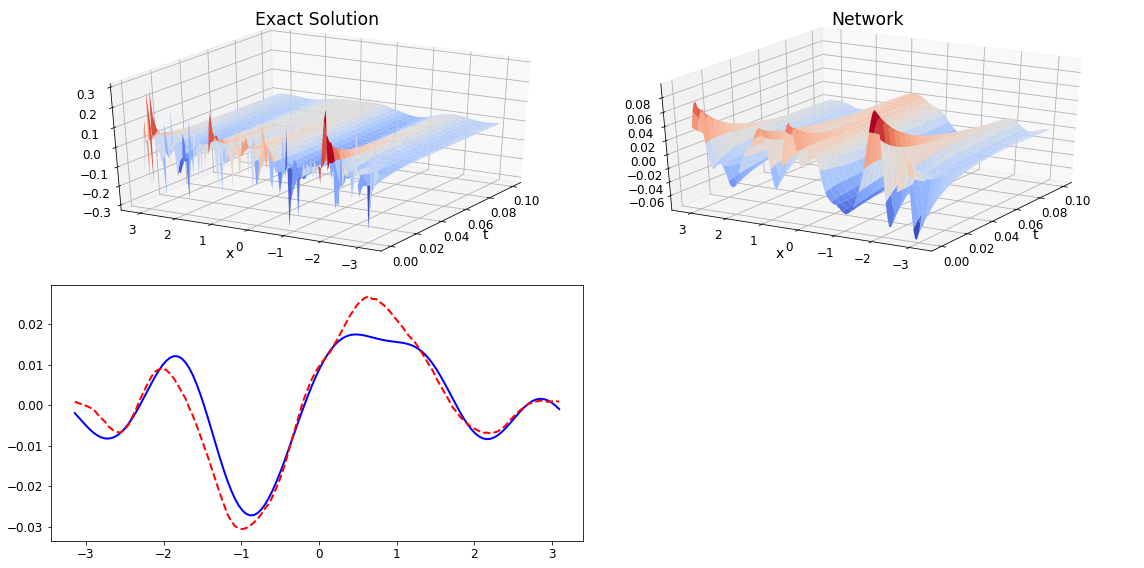

In [146]:
# Inputs
eps = 1
mu = 1
data = 'train'  # 'train', 'val', or 'test'
ind = 3    # index of initial condition

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = test_outputs
    data_tensor = data_test_tensor


# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*(params['len_time']-1),params['len_time'])
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:51,ind,:]

fig = plt.figure(figsize=(16,8)) 

ax = fig.add_subplot(2, 2, 1, projection='3d')
surf = ax.plot_surface(T, X, np.transpose(exact), cmap=plt.cm.coolwarm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize='xx-large')

ax = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax.plot_surface(T, X, np.transpose(outputs[:,ind,:]), cmap=plt.cm.coolwarm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize='xx-large')

ax = fig.add_subplot(2,2,3)
ax.plot(x_pts, exact[50,:], "b-", linewidth=2)
ax.plot(x_pts, outputs[50,ind,:], "r--", linewidth=2)
plt.tight_layout()
plt.show()   

In [25]:
print(np.shape(data_val_tensor))

(2, 1500000, 128)


In [26]:
losses = {'loss1': 1, 'loss2': 2, 'loss3': 3, 'loss4': 4, 'loss5': 5,
              'loss': 6, 'reg_loss': 7, 'regularized_loss': 8,
              'regularized_loss1': 9}
print(losses)

{u'loss': 6, u'regularized_loss1': 9, u'reg_loss': 7, u'loss2': 2, u'loss3': 3, u'loss1': 1, u'regularized_loss': 8, u'loss4': 4, u'loss5': 5}


In [27]:
losses2 = {'loss1': 1, 'loss2': 2, 'loss3': 3, 'loss4': 4, 'loss5': 5,
              'loss': 6, 'reg_loss': 7, 'regularized_loss': 8,
              'regularized_loss1': 9}
print(losses+losses2)

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [28]:
from collections import Counter
dicts = [losses, losses2]
c = Counter()
for d in dicts:
    c.update(d)

In [29]:
print(c)

Counter({u'regularized_loss1': 18, u'regularized_loss': 16, u'reg_loss': 14, u'loss': 12, u'loss5': 10, u'loss4': 8, u'loss3': 6, u'loss2': 4, u'loss1': 2})


In [31]:
print(params['num_traj'])

KeyError: u'num_traj'

In [41]:
print(np.shape(data_val)[0]/51)
print(data_val.shape[0]/51)

30000.0
30000.0


In [46]:
num_val_traj = data_val_tensor.shape[1]/(params['len_time']-params['num_shifts'])
val_batch_size = int(num_val_traj/10)
batch_data_val = data_val_tensor[:, 1*val_batch_size:(1+1)*val_batch_size, :]
print(batch_data_val.shape)

(2, 3000, 128)


In [56]:
val_dicts = []
num_val_traj = data_val_tensor.shape[1]/(params['len_time']-params['num_shifts'])
val_batch_size = int(num_val_traj/10)
for batch_num in xrange(10):
    batch_data_val = data_val_tensor[:, batch_num*val_batch_size:(batch_num+1)*val_batch_size, :]
    print(batch_num*val_batch_size)
    print((batch_num+1)*val_batch_size)
    batch_val_errors_dict = {'loss1': 1, 'loss2': 2, 'loss3': 3, 'loss4': 4, 'loss5': 5,
              'loss': 6, 'reg_loss': 7, 'regularized_loss': 8,
              'regularized_loss1': 9}
    val_dicts.append(batch_val_errors_dict)

val_errors_dict = Counter()
for d in val_dicts:
    val_errors_dict.update(d)

print(val_errors_dict)

0
3000
3000
6000
6000
9000
9000
12000
12000
15000
15000
18000
18000
21000
21000
24000
24000
27000
27000
30000
Counter({u'regularized_loss1': 90, u'regularized_loss': 80, u'reg_loss': 70, u'loss': 60, u'loss5': 50, u'loss4': 40, u'loss3': 30, u'loss2': 20, u'loss1': 10})


In [54]:
def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict

val_dicts = []
num_val_traj = data_val_tensor.shape[1]/(params['len_time']-params['num_shifts'])
val_batch_size = int(num_val_traj/10)
for batch_num in xrange(10):
    batch_data_val = data_val_tensor[:, batch_num*val_batch_size:(batch_num+1)*val_batch_size, :]
    batch_val_errors_dict = {'loss1': 1, 'loss2': 2, 'loss3': 3, 'loss4': 4, 'loss5': 5,
              'loss': 6, 'reg_loss': 7, 'regularized_loss': 8,
              'regularized_loss1': 9}
    val_dicts.append(batch_val_errors_dict)

val_errors_dict = {}
for key in val_dicts[0].keys():
    val_errors_dict[key] = sum(d[key] for d in val_dicts) / len(val_dicts)

print(val_errors_dict)

{u'loss': 6.0, u'regularized_loss': 8.0, u'loss2': 2.0, u'regularized_loss1': 9.0, u'reg_loss': 7.0, u'loss3': 3.0, u'loss1': 1.0, u'loss4': 4.0, u'loss5': 5.0}
10


In [10]:
print(params['num_shifts'])

3
